# Part Two: Visualising Data

## Introduction

This is the second notebook of two outputs.

The first dealt with the extraction, manipulating and cleaning
of the dataset whereas this notebook utilises Python for visualisation
and graph algorithms.

The course content covered in Part Two is

- Exploratory data analysis using Matplotlib (Weeks 7 and 8)
- Graph algorithms and visualisation (Week 11)

In [1]:
# Control whether to display content inline or export to disk
ipython = False

## Exploratory Visualisation

This section contains some simple distribution plots showing the shape of the data
and seeks to answer some exploratory questions about the data.


- How many tube stations are there?
- Which tube stations are the busiest in terms of total train arrivals?
    - Plot the count of vehicle journeys by To_StopName
- What does the distribution of train movements look like throughout the day?
    - Plot the total number of trains online for every half an hour
    - Compare a Monday, Saturday and New Years Day
- What does the distribution of link travel times look like?
    - Histogram of JourneyTime for the set of distinct Links between two stations
    - (Only count a link used between two stations once despite multiple lines using it)


## Tube Map

The London Undergroup map is 86 years old and is considered one of the [great icons of British design](http://www.bbc.co.uk/pressoffice/pressreleases/stories/2006/01_january/27/culture.shtml). Virtually every public
transportation map around the world is based upon its original schematic design.

It's pretty perfect for easily trying to find out which lines to take and which stations to transfer at to get across London. What it doesn't show, is
the relative distances and travel times between each of those stations which can lead to very suboptimal routes.

For example, to get from Paddington to Bond Street, the clearest route on the map is via Notting Hill Gate however this route takes *twice as long* as the optimal (and more hidden) route via Baker St not to mention the two routes are virtually equidistant on the map.

To visualise the underground map using the cleaned dataset from Part One, we need the list of stations along with
the possible links from each station to another. It's enough to just look at the longest "inbound" route for each line because (we would hope) that the "outbound" route is identical.

First, create an empty MultiGraph which allows for multiple links between two stations. For instance, Liverpool St to Farringdon is served by three separate lines.

In [2]:
import networkx as nx
G = nx.MultiGraph()

Now, query the database and add both stations and the edge between them to the graph object.

In [3]:
import psycopg2
import psycopg2.extras

conn = psycopg2.connect(host="localhost",database="londontubepython", user="postgres", password="mysecretpassword")
cur = conn.cursor()

cur.execute("SELECT * FROM inbound_graph")
tablerows = cur.fetchall()

for row in tablerows:
    if row[1] not in G:
        G.add_node(row[1], lon = row[3], lat = row[4])
    if row[2] not in G:
        G.add_node(row[2], lon = row[5], lat = row[6])
    G.add_edge(row[1], row[2], line = row[0])

cur.close()
conn.close()
print('Database connection closed.')

Database connection closed.


In [4]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 269
Number of edges: 429
Average degree:   3.1896


So for the 269 tube stations we're visualising 429 of the links between them.

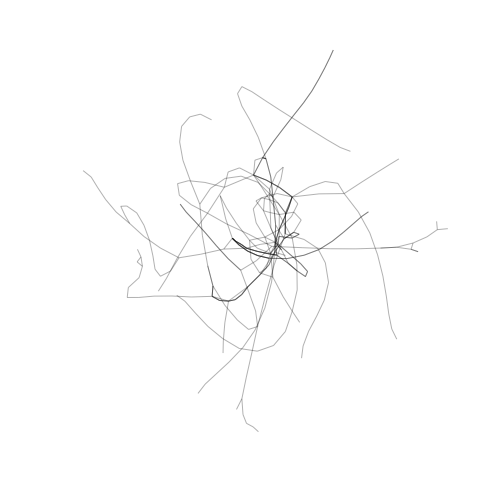

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
from networkx.drawing.nx_agraph import graphviz_layout

options = {
    'node_color': 'b',
    'node_size': 20,
    'width': 1,
    'alpha': 0.3,
    'with_labels': False,
}

plt.subplots(figsize=(7,7))
nx.draw_networkx_edges(G, pos = nx.spring_layout(G), **options)
plt.tight_layout()
plt.axis('off');

Not exactly an icon of British design...

Let's change the layout and add some colour

In [6]:
line_colours = {
        'VIC': (0, 160, 226),
        'PIC': (0, 25, 168),
        'WAC': (118, 208, 189),
        'NTN': (0, 0, 0),
        'HAM': (215, 153, 175),
        'BAK': (137, 78, 36),
        'CIR': (255, 206, 0),
        'DIS': (0, 114, 41),
        'CEN': (220, 36, 31),
        'JUB': (134, 143, 152),
        'MET': (117, 16, 86),
}
# Convert RGB to [0,1] scale
line_colours = {line: tuple([x / 255.0 for x in rgb]) for line, rgb in line_colours.items()}

options = {
    'edges': G.edges(),
    'edge_color': [line_colours[data['line']] for u,v,data in G.edges(data=True)],
    'node_color': 'b',
    'node_size': 20,
    'width': 3,
    'alpha': 1,
    'with_labels': False,
}

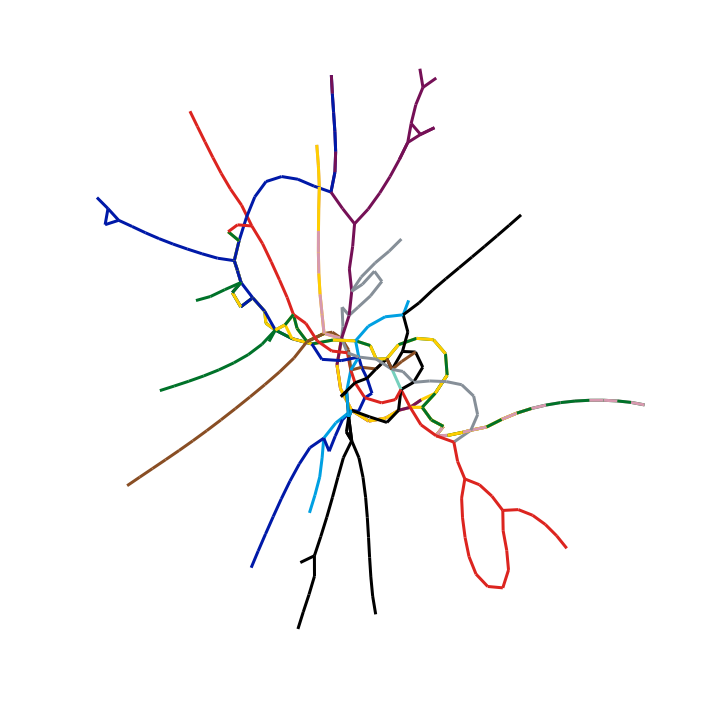

In [7]:
plt.subplots(figsize=(10,10))
nx.draw_networkx_edges(G, pos = graphviz_layout(G, prog = 'neato'), **options)
plt.tight_layout()
plt.axis('off');

Even without any station labels can now discern some of the key features of the network.

- The top left corner is the Heathrow Airport loop on the Piccadily line
- That makes the termini clock-wise and to the right Ealing Broadway and West Ruislip
- The Circle line shares its route with the Hammersmith and City line on its way to...Hammersmith whilst the Picadilly and Metropolitan lines are the same towards Uxbridge.
- The single link of the Waterloo and City line is the cyan line in the center from Waterloo to Bank
- The northeastern loop of the Central line out to Woodford and Epping is in the lower right

Despite these key features, the layout clearly represents nothing geographic.
The Metropolitan line in the top right of the graph is in the North West corner of London so the Jubilee line that joins it will be the Stanmore end. The next intersection along (clockwise) is the Northern line intersecting with the second stop of the Victoria line and therefore must be Stockwell next to Brixton on the completely opposite side of London.

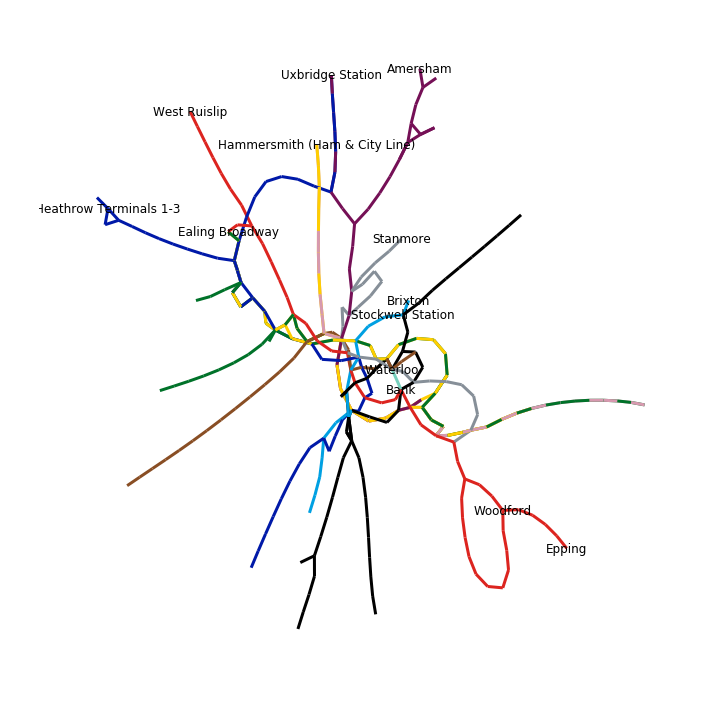

In [8]:
nodes_to_label = ['Heathrow Terminals 1-3', 'Ealing Broadway', 'West Ruislip', 'Waterloo', 'Bank',
                  'Hammersmith (Ham & City Line)', 'Uxbridge Station', 'Woodford', 'Epping', 'Amersham',
                  'Stanmore', 'Stockwell Station', 'Brixton']

labels = {}    
for node in G.nodes():
    if node in nodes_to_label:
        labels[node] = node

plt.subplots(figsize=(10,10))
pos = graphviz_layout(G, prog = 'neato')
nx.draw_networkx_edges(G, pos = pos, **options)
nx.draw_networkx_labels(G, pos, labels, **options)
plt.tight_layout()
plt.axis('off');

The next logical step is to add some realism by showing what the famous tube map doesn't show: the actual positions of stations.

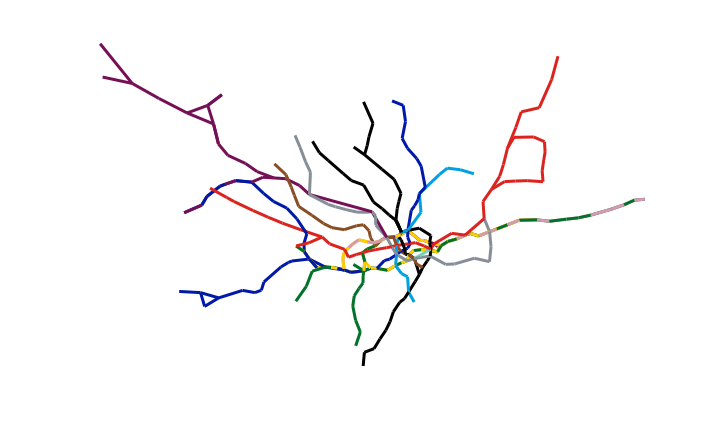

In [9]:
pos = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}

plt.subplots(figsize=(10,6))
nx.draw_networkx_edges(G, pos = pos, **options)
plt.tight_layout()
plt.axis('off');

This is the best version yet but is still heavily distored by plotting lattitude and longitude on the xy-plane.

What about on an actual map of London?

In [10]:
import mplleaflet
import base64

plt.subplots(figsize=(10,10))
nx.draw_networkx_edges(G, pos = pos, width = 2.,
                       edge_color = [line_colours[data['line']] for u,v,data in G.edges(data=True)])

# Use code from mplleaflet.display
fig = plt.gcf()
html = mplleaflet.fig_to_html(fig, tiles='cartodb_positron')
iframe_html = '<iframe src="data:text/html;base64,{html}" width="{width}" height="{height}"></iframe>'\
.format(html = base64.b64encode(html.encode('utf8')).decode('utf8'),
        width = '100%',
        height= int(60.*fig.get_figheight()))

if ipython == True:
    from IPython.core.display import HTML
    HTML(iframe_html)
else:
    out_html = open("tube_map.html","w")
    out_html.write(iframe_html)
    out_html.close()

Here's that infamous section of the network where 30% of people go the wrong way:

![](../paddington_annotated.png)

Seems pretty obvious now which route takes 15mins and which takes 8mins!

## Journey Planner Algorithm

Eyeballing a geographically-accurate map of the network isn't *really* the best way to work out the fastest route from Paddington to Bond Street. The more accurate way would be to weight each edge of our network by the travel time between the two stations and then use a shortest path graph algorithm to find the sequence of edges from station A to station B with the smallest total weight (ie travel time).

It's worth noting that despite the misleading name of "shortest path", since we don't really care how *far* we travel, we want to weight by time rather than distance to get to our destination the fastest way, not the shortest way.

There is one more factor to consider though because modelling the shortest path this way assumes that there is a train ready and waiting to go the moment you want to leave and at every station at which you transfer. With the exception of the Central line in peak hour, this is almost never the case in any transportation network.

**Formulation**

Instead, we model the tube stations using a time-expanded graph network where each node represents a station-*event* rather than a station. In other words, there is a "Hyde Park Corner" node for every arrival and departure of every vehicle into and out of the station. When we lumped WaitTime in with RunTime to create JourneyTime, we simplified the problem to assume that the train's arrival and departure is instantaneous so there's no need to create *both* a departure *and* arrival node.

We then we have two types of edges:
- Travel Edge: Represents the movement of a train from one station to the next
- Stay Edge: Represents waiting at a station for the immediately next train to depart

This does however assume that there is negligible transfer time within a station (when it actually takes +5mins to change from the Victoria line to the Metropolitan line at King's Cross).



Due to the size of the Departures Board, we'll extract the full network timetable just for any given Monday.

In [11]:
timetable_date = '2017-12-18'

# Placeholder for timetable_date in the table-valued function `departureboard`
sqlquery = ('SELECT * FROM departureboard(%s) '
            'ORDER BY "From_StopPointName", "DepartureMins_Link", "VehicleJourneyCode" ')

Unlike the Tube Map model, we want to model the network using a Directed Graph instead of a Multi Graph because each
train is travelling in a specific direction and no vehicle travels the same link at the same time.

Looping through each row in the Departure Board query we add a node for each station-vehicle pair. In the case where
the station is the terminus, we need to add the arrival node as well as the departure node.

The first edge added is simply the train's movement whereas the second edge is the 'stay' edge from that train's arrival to the next train's departure from the same station.

In [12]:
H = nx.DiGraph()

from copy import deepcopy
prev_row = None

conn = psycopg2.connect(host="localhost",database="londontubepython", user="postgres", password="mysecretpassword")
cur = conn.cursor('server_side_cursor', cursor_factory=psycopg2.extras.DictCursor)
cur.execute(sqlquery, (timetable_date,))

for row in cur:
    
    # Add or update node data for the Departure node in this row
    H.add_node(row['VehicleJourneyCode'] + '//' + row['From_StopPointRef'],
               VehicleJourneyCode = row['VehicleJourneyCode'],
               StopPointName = row['From_StopPointName'],
               MinuteOfDay = row['DepartureMins_Link'])
    
    # If this is the last stop for a train then add or update
    # node data for the Arrival node in this row
    if row['Flag_LastStop'] == True:
        H.add_node(row['VehicleJourneyCode'] + '//' + row['To_StopPointRef'],
               VehicleJourneyCode = row['VehicleJourneyCode'],
               StopPointName = row['To_StopPointName'],
               MinuteOfDay = row['ArrivalMins_Link'])
    
    # Create Travel edge
    H.add_edge(row['VehicleJourneyCode'] + '//' + row['From_StopPointRef'],
               row['VehicleJourneyCode'] + '//' + row['To_StopPointRef'],
               movement = row['Line'],
               # Edge weight is the travel time between stations
               cost = row['JourneyTime'])
    
    # Create Stay edge from the previous departure row provided it's the same station
    # NB: The result set is ordered by Departure Station, Departure Time so every station's
    #     departures are grouped and ordered together.
    if prev_row is not None and prev_row['From_StopPointName'] == row['From_StopPointName']:
        H.add_edge(prev_row['VehicleJourneyCode'] + '//' + prev_row['From_StopPointRef'],
                   row['VehicleJourneyCode'] + '//' + row['From_StopPointRef'],
                   movement = 'Stay',
                   # Edge weight is the waiting time between departures
                   cost = row['DepartureMins_Link'] - prev_row['DepartureMins_Link'])
    
    prev_row = deepcopy(row)
    

cur.close()
conn.close()

We're now ready to query the timetable.

The query format contains the start and end stations with the departure time in minutes after midnight.
Once that's provided, we can modify the graph with two 'helper' nodes ('Start and 'End') which signify the origin and destination
of the query. These are then linked to each of their station's vehicle departures and arrivals respectively provided those movements happen after the query time of course.

In [13]:
path_query = {
    'From_StopPointName': 'Liverpool St',
    'To_StopPointName': 'Hyde Park',
    'time': 23 * 60,
    'leave_after': True
}

In [14]:
def setup_shortest_path(path_query):
    
    # For "Leave After" query, assign the leaving time to the start node and leave arriving time as unknown
    if path_query['leave_after'] == True:
        H.add_node('Start', StopPointName = path_query['From_StopPointName'], MinuteOfDay = path_query['time'], movement = 'Departure')
        H.add_node('End', StopPointName = path_query['To_StopPointName'], MinuteOfDay = None, movement = 'Arrival')
    
    # For "Arrive Before" query, assign the arriving time to the end node and leave departure time as unknown
    else:
        H.add_node('Start', StopPointName = path_query['From_StopPointName'], MinuteOfDay = None, movement = 'Departure')
        H.add_node('End', StopPointName = path_query['To_StopPointName'], MinuteOfDay = path_query['time'], movement = 'Arrival')

    for n, n_data in H.nodes(data=True):
        # Don't want to add an edge from 'Start' to 'End', 'End' to 'End' or 'Start' to 'Start'
        if n == 'Start' or n == 'End':
            continue

        if path_query['leave_after'] == True:
            # Cannot catch a train that has already left
            if n_data['MinuteOfDay'] >= path_query['time']:

                if path_query['From_StopPointName'] in n_data['StopPointName']:
                    H.add_edge('Start', n, movement = 'Start', cost = n_data['MinuteOfDay'] - path_query['time'])

                if path_query['To_StopPointName'] in n_data['StopPointName']:
                    H.add_edge(n, 'End', movement = 'End', cost = 0)
        
        else:
        
            # No point catching a train that leaves after we want to arrive
            if n_data['MinuteOfDay'] <= path_query['time']:

                if path_query['From_StopPointName'] in n_data['StopPointName']:
                    H.add_edge('Start', n, movement = 'Start', cost = 0)

                if path_query['To_StopPointName'] in n_data['StopPointName']:
                    H.add_edge(n, 'End', movement = 'End', cost = path_query['time'] - n_data['MinuteOfDay'])

Next, due to the formulation of our network, the raw path isn't going to be terribly pretty so we can define some conditions to print only the information an end-user wants to know; when to get on or off a train.

In [15]:
def minutes_to_time(minutes_past_midnight):
    hours, remainder = divmod(minutes_past_midnight * 60, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(hours, minutes, int(seconds))
    

def print_path(path):
    for u,v in zip(path,path[1:]):
        u_data = H.nodes(data=True)[u]
        v_data = H.nodes(data=True)[v]
        edge_data = H[u][v]

        if edge_data['movement'] == 'Start':
            print('Start journey from {} at {}\n'.format(u_data['StopPointName'], minutes_to_time(v_data['MinuteOfDay'] - edge_data['cost'])))
        elif previous_edge['movement'] == 'Start' or (previous_edge['movement'] == 'Stay' and previous_edge['movement'] != edge_data['movement']):
            print('Board the {:>7} line train from {} at {}'.format(edge_data['movement'], u_data['StopPointName'], minutes_to_time(u_data['MinuteOfDay'])))
        elif edge_data['movement'] != previous_edge['movement'] and edge_data['movement'] == 'Stay':
            print('Disembark the {:>3} line train at {} at {}'.format(previous_edge['movement'], u_data['StopPointName'], minutes_to_time(u_data['MinuteOfDay'])))
        elif edge_data['movement'] == 'End':
            print('\nFinish journey at {} at {}'.format(u_data['StopPointName'], minutes_to_time(u_data['MinuteOfDay'])))

        previous_edge = edge_data

Finally, putting this all together we can define a "journey planner" function.

Running a query happens near-instantaneously as the network isn't very large even with the time-expanded formation as we have filtered down to one day. The SQL query to pull the Departures Board is comparatively much slower.

In [16]:
def plan_journey(path_query):
    setup_shortest_path(path_query)
    path = nx.shortest_path(H, source='Start', target='End', weight='cost')
    print_path(path)
    H.remove_nodes_from(['Start', 'End'])

In [17]:
# Leave after 11pm
plan_journey(path_query)

Start journey from Liverpool St at 23:00:00

Board the     CEN line train from Liverpool Street Station at 23:01:00
Disembark the CEN line train at Holborn Station at 23:08:00
Board the     PIC line train from Holborn Station at 23:09:00

Finish journey at Hyde Park Corner at 23:17:00


In [25]:
# Arrive before 11pm
path_query['leave_after'] = False
plan_journey(path_query)

Start journey from Paddington at 19:31:00

Board the     BAK line train from Paddington at 19:31:00
Disembark the BAK line train at Baker Street Station at 19:36:00
Board the     JUB line train from Baker Street Station at 19:36:00

Finish journey at Bond Street Station at 19:38:00


In [26]:
path_query['leave_after'] = True
path_query['From_StopPointName'] = 'Heathrow'
path_query['To_StopPointName'] = 'Canada Water'
path_query['time'] = 19.683 * 60
plan_journey(path_query)

Start journey from Heathrow at 19:40:58

Board the     PIC line train from Heathrow Terminals 1-3 at 19:41:00
Disembark the PIC line train at Hounslow East at 19:51:00
Board the     PIC line train from Hounslow East at 19:52:00
Disembark the PIC line train at Gloucester Road at 20:20:00
Board the     CIR line train from Gloucester Road at 20:21:00
Disembark the CIR line train at Westminster at 20:30:00
Board the     JUB line train from Westminster at 20:30:00

Finish journey at Canada Water Station at 20:39:00


In the event that you have to wait an extra four seconds for your baggage to appear at the carousel
you'll want to take the District and Victoria lines instead of the Circle line...

In [27]:
path_query['time'] = 19.684 * 60
plan_journey(path_query)

Start journey from Heathrow at 19:41:02

Board the     PIC line train from Heathrow Terminals 1-3 at 19:46:00
Disembark the PIC line train at Earl's Court at 20:21:00
Board the     DIS line train from Earl's Court at 20:22:00
Disembark the DIS line train at Victoria at 20:31:00
Board the     VIC line train from Victoria at 20:31:00
Disembark the VIC line train at Green Park at 20:32:00
Board the     JUB line train from Green Park at 20:33:00

Finish journey at Canada Water Station at 20:44:00


...and just in case it wasn't already clear from a geographically accurate tube map...

In [28]:
path_query['From_StopPointName'] = 'Paddington'
path_query['To_StopPointName'] = 'Bond'
plan_journey(path_query)

Start journey from Paddington at 19:41:02

Board the     BAK line train from Paddington at 19:43:00
Disembark the BAK line train at Baker Street Station at 19:48:00
Board the     JUB line train from Baker Street Station at 19:48:00

Finish journey at Bond Street Station at 19:51:00


# Trains Moving Throughout the Network

The most complex visualisations involving spatiotemporal data involve trying to look at
the space and time dimensions simultaneously. The interactive javascript tube map seen
earlier is a good way to visualise a static representation of the network. However since
we are working with timetable data which inheritantly contains the *movement of trains over time*
then the final step would be to plot these train movements over time.

For the final section of the project, we will look at visualising the movement of tube vehicles
across a map of central London over the course of a day.

Begin by choosing the date of timetables we want to visualise:

In [29]:
timetable_date = '2017-12-20'

We'll need to use our tube line graph `G` from the Tube Map section so ensure that is loaded first.
The Departures Board query from the Shortest Path section is also needed however this time the whole table is
to be loaded into a DataFrame.

Annoyingly `pandas` requires that every column be explicitly listed however this is much faster than the alternative of adding an SQLAlcehmy layer.

In [30]:
import pandas as pd

conn = psycopg2.connect(host="localhost",database="londontubepython", user="postgres", password="mysecretpassword")
cur = conn.cursor()
cur.execute('SELECT * FROM departureboard(%s)', (timetable_date,))

df = pd.DataFrame(cur.fetchall(), columns=['VehicleJourneyCode', 'Line', 'From_StopPointRef', 'From_StopPointName', 'From_Longitude', 'From_Latitude',
'To_StopPointRef', 'To_StopPointName', 'To_Longitude', 'To_Latitude', 'JourneyTime', 'DepartureMins_Link',
'ArrivalMins_Link', 'Flag_LastStop'])

The problem with the structure of the Departures Board query is that it's returned a dataset where every row
constitutes the departure of a train from any station. In order to plot the train movements we need to know
where they are *between* departures *continuously*. One train may leave one station at say 7:00pm and not arrive at the next station for 5 minutes meanwhile another train has visited three stations in that time.

This can be solved by pivotting the dataset from the point of view of a *train time of departure* to a
*train location by time*.

Pivotting in this manner means that we need to choose a sampling frequency for the train location
calculation. The dataset is already rounded to the nearest 60 seconds however some tube links only
take 60 seconds to travel between which would cause the resulting animation to show trains teleporting
between stations. Two clever values are to sample every 12 or 20 seconds because then two trains approaching
each other from two stops that are 60 seconds apart won't overlap on the plot.

The other consideration when pivotting is that the dataset doesn't include the location of the terminus.
The final row of a vehicle is the departure time of the penultimate stop with the arrival time of the terminus.
Therefore we also need to pull out all these termini, shift the columns to align with the departures and 
append them onto the departures table.


In [31]:
# Select required columns
df_expanded = df[['VehicleJourneyCode', 'Line', 'Flag_LastStop', 'DepartureMins_Link', 'ArrivalMins_Link',
                  'From_Longitude', 'From_Latitude', 'To_Longitude', 'To_Latitude']]

# Subset to the last trip link of each vehicle and rename the "arrival" columns to be "departure" columns
# to allow for automatic concatenation by column name
columns_to_shift = {'ArrivalMins_Link':'DepartureMins_Link',
                    'To_Longitude':'From_Longitude',
                    'To_Latitude':'From_Latitude'}
df_laststop = df_expanded.loc[df_expanded['Flag_LastStop'] == True].drop(columns_to_shift.values(), axis=1)
df_laststop.rename(columns = columns_to_shift, inplace = True)
df_expanded = pd.concat([df_expanded.drop(columns_to_shift.keys(), axis=1), df_laststop])

# Cast the "DepartureMins_Link" column to be a TimeDelta object and set it as a MultiIndex with "VehicleJourneyCode"
df_expanded = df_expanded.set_index(pd.to_timedelta((df_expanded['DepartureMins_Link']).astype('int'), unit='m'))
df_expanded = df_expanded.groupby('VehicleJourneyCode')

In [32]:
def resample_vehicle_departures(df_expanded, sample_freq):
    # Expand the trip start and end times of every "VehicleJourneyCode" by sample_freq seconds
    df_resampled = df_expanded.resample(str(sample_freq) + 'S').asfreq()
    
    # Fill in the Line for each vehicle
    df_resampled['Line'] = df_resampled['Line'].ffill().bfill()
    
    # Linearly interpolate the Latitude and Longitude
    df_resampled = df_resampled.interpolate(method='linear')
    
    # Drop unneeded columns
    df_resampled = df_resampled.drop(['VehicleJourneyCode', 'DepartureMins_Link', 'Flag_LastStop'], 1)
    df_resampled = df_resampled.reset_index()

    return df_resampled

In [33]:
sample_freq = 20 # interpolate the vehicle location every sample_freq seconds
df_resampled = resample_vehicle_departures(df_expanded, sample_freq)

In [34]:
# Show vehicle positions as at 11:03:40
h,m,s = 12,3,20
assert s % sample_freq == 0 # seconds are a multiple of sample_freq otherwise no data returned
time = pd.to_timedelta((h*60 + m)*60 + s, unit='s')
df_resampled.loc[df_resampled['DepartureMins_Link'] == time].head()

,VehicleJourneyCode,DepartureMins_Link,Line,From_Longitude,From_Latitude
1233,VJ_1-BAK-_-y05-430200-1068-T0,12:03:20,BAK,-0.272943,51.542740
6699,VJ_1-BAK-_-y05-430200-1151-T0,12:03:20,BAK,-0.167915,51.521039
9680,VJ_1-BAK-_-y05-430200-1195-T0,12:03:20,BAK,-0.203442,51.534327
10816,VJ_1-BAK-_-y05-430200-1217-T0,12:03:20,BAK,-0.323241,51.585585
13268,VJ_1-BAK-_-y05-430200-1246-T0,12:03:20,BAK,-0.132818,51.509221


This dataset is now in the perfect structure for finding the exact location of any vehicle for any discrete
point in time by subsetting on the `DepartureMins_Link` column.

For the animation we'll need a few additional packages in addition to `matplotlib.animation`.
The `smopy` module provides the OpenStreetMap
tile which we'll be plotting on, `numpy` provides a useful function `np.c_` for concatenating series and
`IPython` purely for displaying the final product in Jupyter.

In [35]:
import smopy
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from IPython.display import HTML
%matplotlib inline

Firstly, set the start and finish times of the animation.

In [36]:
# Set the animation start time in minutes past midnight
start_time = 5.5 * 60 # 5:30am
end_time = 8 * 60 # 8:00am

The `create_train_timetable_animation` function constists of four parts:
1. Setting up the base layer of the plot
2. Defining the initial state of the animation in `init`
3. Defining what each sequential frame of the animation looks like for a given frame number `i` with `animate`
4. Returning the `FuncAnimation` object for a given number of frames calculated from the
`start_time`, `end_time` and `sample_freq`

The first part downloads the same OSM layer we used for the Tube Network previously but using `smopy`
and then defines the region of interest as central London. Then setup the plot area, add the map layer
and plot an empty scatter plot with an empty annotation. The scatter will show the locations of each train
and the annotation will tell us the time of day for that frame.

The `init` function is just a replica of the Tube Map plot as this will be part of the base layer with
a change to the `alpha` level to make it more faint.

The `animate` function takes a frame number as input, calculates the current time using the `start time`
and `sample_freq` and subsets `df_resampled` to the vehicle positions at that time. Finally we map the
latitude and longitude coordinates to pixel positions on the plot, map the tube line to an RGB colour
and plot!

In [37]:
def convert_to_time(timedelta):
    hours, remainder = divmod(timedelta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours, minutes, seconds

def create_train_timetable_animation(start_time, end_time):
    # Setup
    smopy.TILE_SERVER = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}@2x.png"
    smopy.TILE_SIZE = 512

    # Set map bounds around central London
    map = smopy.Map((51.45, -0.3, 51.55, -0.05), z = 12)

    # Setup plot
    fig = plt.figure(figsize=(7, 7), dpi=None)
    ax = plt.subplot(111)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlim(0, map.w)
    plt.ylim(map.h, 0)
    plt.axis('off')
    plt.tight_layout()

    ax = map.show_mpl(ax=ax);

    x, y, c = [],[],[]
    scat = ax.scatter(x=x,y=y,c=c,s=7)
    current_time = ax.text(35, 70, s='', fontsize=15)

    def init():
        options['alpha'] = 0.2
        pos = {node: map.to_pixels(data['lat'], data['lon']) for node, data in G.nodes(data=True)}
        nx.draw_networkx_edges(G, pos = pos, **options)
        scat.set_offsets([])
        current_time.set_text('')
        return scat,current_time

    seconds_in_minute = 60
    minutes_to_animate = end_time - start_time
    def animate(i):
        # Calculate the time (in seconds past midnight) of the frame number
        # by using the sample_freq of df_resampled
        time_now = start_time * seconds_in_minute + i * sample_freq

        # Cast time to a timedelta object and subset df_resampled
        time_td = pd.to_timedelta(time_now, unit='s')
        df_now = df_resampled.loc[df_resampled['DepartureMins_Link'] == time_td]

        # Map lat, lon and colours
        x_pixel, y_pixel = map.to_pixels(df_now['From_Latitude'], df_now['From_Longitude'])
        frame_colouring = df_now['Line'].map(line_colours)

        # Plot frame
        scat.set_offsets(np.c_[x_pixel, y_pixel])
        scat.set_color(frame_colouring)
        current_time.set_text('{:02d}:{:02d}:{:02d}'.format(*convert_to_time(time_td)))

        return scat,current_time

    # Animate with the number of frames calculated from start_time, end_time and sample_freq
    # blit = True means only re-draw the parts that have changed
    anim = animation.FuncAnimation(fig, animate, init_func=init, interval=60, blit=True,
                                   frames = int(minutes_to_animate*(seconds_in_minute/sample_freq)))
    return anim

def export_animation(anim, name):
    if ipython == True:
        return HTML(anim.to_html5_video())
    else:
        anim.save(name, writer='ffmpeg')

To see this is action, let's look at three key periods of the day.

First thing in the morning...

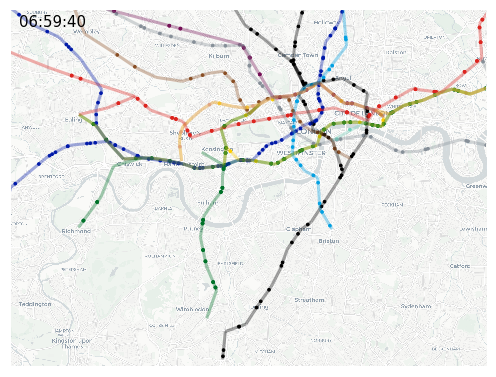

In [38]:
# 4:45am to 7:00am
start_time, end_time = 4.75 * 60, 7 * 60
anim_early = create_train_timetable_animation(start_time, end_time);
export_animation(anim_early, 'anim_early.mp4')

... peak hour in the afternoon ...

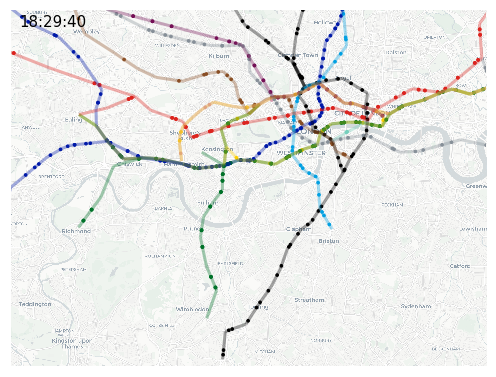

In [39]:
# 5:30pm to 6:30pm
start_time, end_time = 17.5 * 60, 18.5 * 60
anim_peak = create_train_timetable_animation(start_time, end_time);
export_animation(anim_peak, 'anim_peak.mp4')

... and last thing at night.

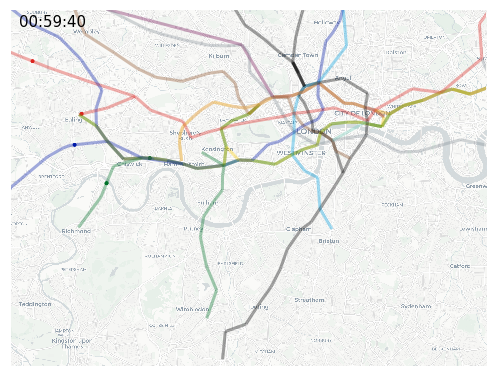

In [40]:
# 11:30pm to 1:30am
start_time, end_time = 23.5 * 60, 25 * 60
anim_late = create_train_timetable_animation(start_time, end_time);
export_animation(anim_late, 'anim_late.mp4')

In this last plot, the timedelta object will handle the `end_time` wrapping to the next day because it converts it back to the start of our dataset. There's no jump in any of the train positions at midnight because the timetable for the
21st December is probably identical to 20th December with them both being weekdays. It may be a different story if plotting a Sunday night into a Monday morning.

Of course, if you really wanted, you could sit and watch an entire day of train movements...